## What you learn

Modelが意図した通りに構築されているか、インプット、プロセス、アウトプットの観点から評価しTest Reportを作成します。Test Reportには、Business goalを達成できているかの評価を含める。

## Why you need

通常のソフトウェア開発と同様、機械学習モデルも品質を担保するためにテストを行う必要があります。また、ステークホルダーに対しBusiness goalがどの程度達成できているかの評価レポートを作成する必要があります。

## How to do

機械学習モデルの品質は、3つの観点からテストが必要です。インプットとプロセスは通常のプログラムであるため、Unit Testが可能です。Technical Exerciseでは3にフォーカスします。

1. インプット
   * 入力データの質と量
2. プロセス
   * データの学習・加工プロセス
3. アウトプット
   * モデルの性能
   * モデルの頑健性
   * 機械学習システム全体の評価 (ビジネス上の評価)

### Technical Exercise

モデルの性能評価としては、今回は回帰であるため、二乗平均平方根誤差と決定係数で評価します。

テスト用のデータ、学習したモデル、前処理用のエンコーダーを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


test_data_path = Path("../data/processed/test.csv")
test_df = pd.read_csv(test_data_path)

In [2]:
from pathlib import Path
from joblib import load


model = load(Path("../model/model.joblib")) 
encoder = load(Path("../model/encoder.joblib"))

モデルで予測を行います。

In [3]:
X = test_df.drop("SalePrice", axis=1)
y = test_df["SalePrice"]

prediction = model.predict(X)

入力のX、出力のyをそれぞれ前処理前の形式に戻す処理を定義します。内部的には、前処理に使用した`StandardScaler`や`OrdinalEncoder`で変換の逆を行う`inverse_transform`を呼び出しています。

In [4]:
def inverse_Xy(X, y):
    numerical_columns = encoder.named_transformers_["standardscaler-1"].feature_names_in_
    categorical_columns = encoder.named_transformers_["ordinalencoder"].feature_names_in_

    inversed_numerical = encoder.named_transformers_["standardscaler-1"].inverse_transform(X[numerical_columns])
    inversed_categorical = encoder.named_transformers_["ordinalencoder"].inverse_transform(X[categorical_columns])
    inversed_y = encoder.named_transformers_["standardscaler-2"].inverse_transform(y.values.reshape((-1, 1)))

    inversed_numerical_df = pd.DataFrame(inversed_numerical, columns=numerical_columns)
    inversed_categorical_df = pd.DataFrame(inversed_categorical, columns=categorical_columns)
    inversed_df = pd.concat([inversed_numerical_df, inversed_categorical_df, 
                             pd.Series(inversed_y.flatten(), name=y.name)], axis=1)
    
    return inversed_df

In [5]:
original_df = inverse_Xy(X, y)
prediction_df = inverse_Xy(X, pd.Series(prediction.flatten(), name="SalePricePredicted"))

In [6]:
from sklearn.metrics import mean_squared_error, r2_score


rmse = mean_squared_error(original_df["SalePrice"], prediction_df["SalePricePredicted"], squared=False)
r2 = r2_score(original_df["SalePrice"], prediction_df["SalePricePredicted"])

print(f"Mean squared error {rmse}, R2 {r2}")

Mean squared error 31658.313256313446, R2 0.823463417636467


住宅の価格が100,000ドル~と考えると、二乗平均平方根誤差は満足できそうな値です。1に近いほど良い決定係数も同様です。実際と予測とで、価格の分布が近しいこともわかります。

<AxesSubplot:ylabel='Frequency'>

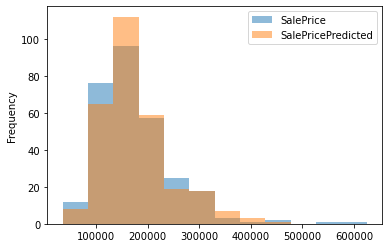

In [7]:
pd.concat([original_df["SalePrice"], prediction_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

入力の変化に応じた出力の変化が起きているかでモデルの頑健性を評価する手法をメタモルフィックテストと呼びます。モデルの出力が予測の範囲内に収まるかどうかを検証するのに有効なテストです。

モデルの着目している特徴を分析し、値を2分の1、2倍に変化させてみましょう。

In [8]:
changed_df = test_df.copy()
changed_df["OverallQual"] = changed_df["OverallQual"] + 2.0

In [9]:
changed_X = changed_df.drop("SalePrice", axis=1)
changed_y = changed_df["SalePrice"]


changed_prediction = model.predict(changed_X)

In [10]:
changed_prediction_df = inverse_Xy(changed_X, pd.Series(changed_prediction.flatten(), name="SalePriceChanged"))

<AxesSubplot:ylabel='Frequency'>

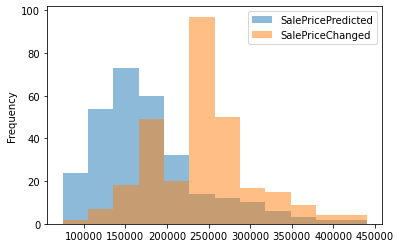

In [11]:
pd.concat([prediction_df["SalePricePredicted"], changed_prediction_df["SalePriceChanged"]], axis=1).plot.hist(bins=12, alpha=0.5)

価格の分布が大きくずれていることがわかります。

モデルの性能と頑健性が、Business goalのうち機械学習モデルの担当分であるModel Usage Impactの達成に十分であるかはDomain Expertの協力を得ながら検証する必要があります。

### Communication Exercise

Data Scientistとして機械学習モデルのテストを行うにあたり、誰にどのような質問をする必要がありますか?

* Product Manager
* Business Analyst
* Data Analyst
* Architect 
* DevOps Engineer
* Software Engineer
* Operator
* System Admin
* IT Auditor
* Data architect
* Domain Expert

#### Example

* Domain Expert
   * 業務上頻繁なケースについて、機械学習モデルの予測はどれぐらい利用できますか?(100%、80%、50%、20%など)
   * 予測を確認するための工数は値付けをする工数に比べてどの程度下がりますか。
* Product Manager
   * 機械学習モデルをリリースしていくために、追加で検証すべきシナリオや合意しておくべきステークホルダーはいますか。

## Next Step

[おわりに](../docs/ending.md)

## References

1. 佐藤直人, 小川秀人, 來間啓伸 and 明神智之. [AIソフトウェアのテスト](https://www.amazon.co.jp/dp/B095W5VGB3/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2021.

関連するAWSのサービス

1. Model Monitor
2. SageMaker Model Registry
